<a href="https://colab.research.google.com/github/JanaDeCoster/Machine_Learning_course_UGent_D012554_kaggle/blob/master/Kaggle_eye_blinking_prediciton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
import pandas as pd;
import warnings;
warnings.filterwarnings('ignore');
import matplotlib.pyplot as plt;
import numpy as np;
import seaborn as sns;

#Eye blinking prediction

The goal of this project is to find a model that wil be trained on a train dataset and that will perform well on the test dataset. The results of fitting this model on the test dataset will be scored in Kaggle to see how well the prediction of the model are.

The following data will be sed as test- and train datasets.

In [0]:
trainset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_train.csv")

testset = pd.read_csv("https://raw.githubusercontent.com/sdgroeve/Machine_Learning_course_UGent_D012554_kaggle/master/eeg_test.csv")

## Pre-processing

The first step in this process would be to pre-process or standardize. This has to be done since feature values can have different scales (so different minimum and different maximum values). 

So we will do this as well for our datasets (both the test- and train dataset).


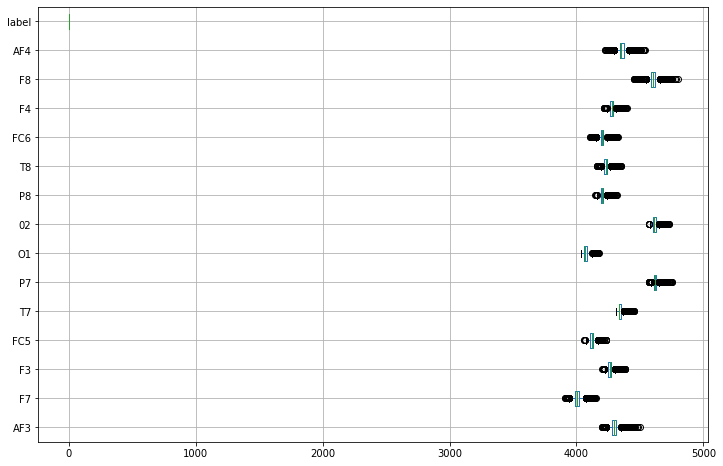

In [7]:
plt.figure(figsize=(12,8))
trainset.boxplot(vert=False)
plt.show()

This plot shows us that data normalization will most defenitly be necessary.

This normalization can either be done by standardization or by scaling the data.

We will just plot both of these aproaches to take a look how this actually works.


Firts we will try **standardization**. This method scales the features such that they will have the properties of a normal distribution ($\mu = 0$ and $\sigma = 1$). 

\begin{equation} x_{norm} = \frac{x - \mu}{\sigma}\end{equation} 


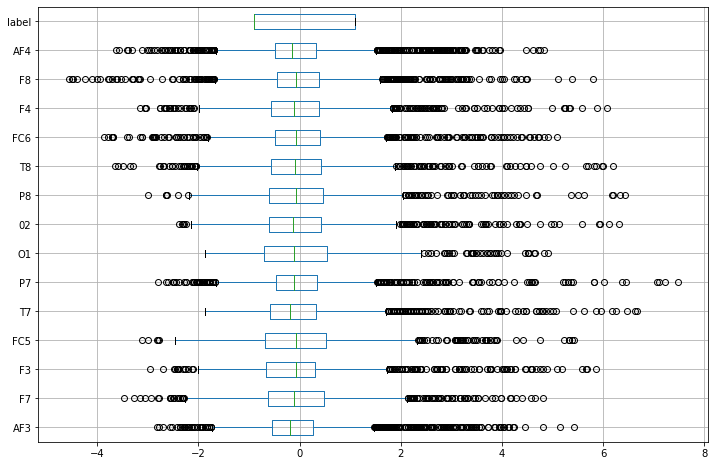

In [8]:
from sklearn.preprocessing import StandardScaler

trainset_columns = trainset.columns.values
scaler = StandardScaler()
scaler.fit(trainset)
trainset_stand = pd.DataFrame(scaler.transform(trainset),columns=trainset_columns)
plt.figure(figsize=(12,8))
trainset_stand.boxplot(vert=False)
plt.show()

The other method we can use is the **scaling method**. This uses the following equation:
 \begin{equation} x_{norm} = \frac{x - x_{min}}{x_{max}-x_{min}} \end{equation}
In this equation $x_{min}$ and $x_{max}$ represent the minimum and maximum values respectively.

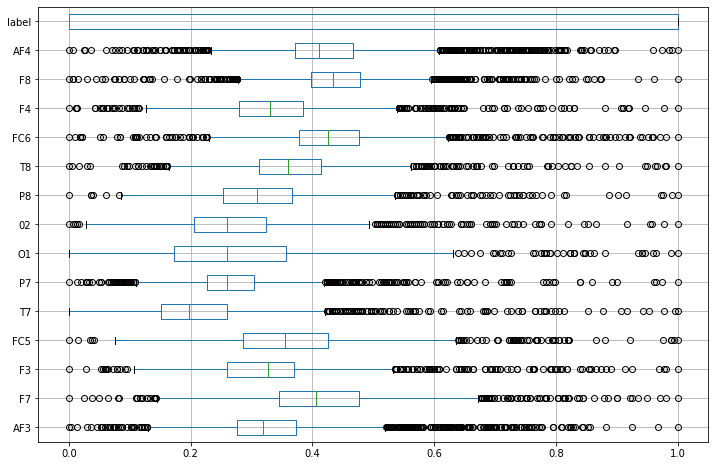

In [9]:
from sklearn.preprocessing import MinMaxScaler

trainset_columns = trainset.columns.values
scaler = MinMaxScaler()
scaler.fit(trainset)
trainset_scaling = pd.DataFrame(scaler.transform(trainset),columns=trainset_columns)
plt.figure(figsize=(12,8))
trainset_scaling.boxplot(vert=False)
plt.show()

I will choose the first method 